# google apps数据探索性分析
本数据来自kaggle:[链接](https://www.kaggle.com/lava18/google-play-store-apps)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
path = r'data/google-play-store-apps/googleplaystore.csv'
pf = pd.read_csv(path)
pf.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [3]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
pf.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


## 描述数据：
- 本数据为google app store的部分apps的信息，包括  
    - app名
    - app类别
    - 评分
    - 评论数
    - 大小
    - 安装数量
    - 是否收费
    - 收费价格
    - 分级
    - 流派
    - 最后更新日期
    - 最新版本
    - 安卓版本
- 除Rating这一列外，其它列都是string类型，有些列需要转换成number以方便后续处理。

## 清洗数据

In [5]:
# 备份
pf_clean = pf.copy()

### 1. 首先处理Size这一列
这一列中的数字后面都有一个M或者k作为单位，也有一些“Varies with device”，还有一些“1,000+”。把含有数字的值替换为float格式（其中的“1,000+”粗略替换为1000）单位都换算成Mb，不包含数字的值替换为Nan.

In [6]:
# 去掉“M”
pf_clean.Size = pf_clean.Size.str.replace('M', '')

In [7]:
def kb_to_Mb(obj):
    """把所有的k替换为M，所以要除以1000"""
    if 'k' in str(obj):
        obj = str(obj).replace('k', '')
        obj = float(obj) / 1000
    return obj

pf_clean.Size = pf_clean.Size.apply(kb_to_Mb)

In [8]:
pf_clean.Size = pf_clean.Size.replace('1,000+', 1000)

In [9]:
pf_clean.Size = pf_clean.Size.replace('Varies with device', np.nan)

In [10]:
pf_clean.Size = pf_clean.Size.astype('float64')

In [11]:
# 测试
pf_clean.Size.describe()

count    9146.000000
mean       21.623514
std        24.796747
min         0.008500
25%         4.900000
50%        13.000000
75%        30.000000
max      1000.000000
Name: Size, dtype: float64

### 2.处理 reviews这里列
这一列大多数都是数字形式，有少数以‘M’结尾

In [12]:
def M_to_num(obj):
    if 'M' in str(obj):
        obj = obj.replace('M', '')
        obj = float(obj) * 1000000
    return obj
pf_clean.Reviews = pf_clean.Reviews.apply(M_to_num)

In [13]:
pf_clean.Reviews = pf_clean.Reviews.astype('int64')

In [14]:
# 测试
pf_clean.Reviews.describe()

count    1.084100e+04
mean     4.443887e+05
std      2.927728e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.479800e+04
max      7.815831e+07
Name: Reviews, dtype: float64

### 3. 处理Price这一列
这一列中有些价格包含美元符“$”，还有一行（index==10472）的值为‘Everyone’,明显是搞错了，应该是下一列的值，我们也处理一下

In [15]:
pf_clean.Price = pf_clean.Price.str.replace('$', '')
pf_clean.Price[10472] = np.nan
pf_clean['Content Rating'][10472] = 'Everyone'
pf_clean.Price = pf_clean.Price.astype('float64')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# 测试
pf_clean.Price.describe()

count    10840.000000
mean         1.027368
std         15.949703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price, dtype: float64

### 4.处理Install这一列
这一列大都包含‘+’，可以粗略的去掉‘+’再转换为int。
<br>
从分析中我注意到，index为10472的这一行部分数据出现错位，干脆删除

In [17]:
pf_clean.Installs = pf_clean.Installs.str.replace('+', '')
pf_clean.Installs = pf_clean.Installs.str.replace(',', '')

In [18]:
pf_clean = pf_clean.drop(10472)

In [19]:
pf_clean.Installs = pf_clean.Installs.astype('int64')

In [20]:
# 测试
pf_clean.Installs.describe()

count    1.084000e+04
mean     1.546434e+07
std      8.502936e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

### 5. 最后更新时间
改成时间类型

In [21]:
pf_clean['Last Updated'] = pd.to_datetime(pf_clean['Last Updated'])

### 清洗完成

In [22]:
pf = pf_clean.copy()

## EDA
除了探索变量的分布特征外，我主要关注的是安装数，因为对于一款APP来说，安装数越多，用户数量就越多，也就越容易盈利。

### 1. 单变量探索
app名
app类别
评分
评论数
大小
安装数量
是否收费
收费价格
分级
流派
最后更新日期
最新版本
安卓版本

####  app类别

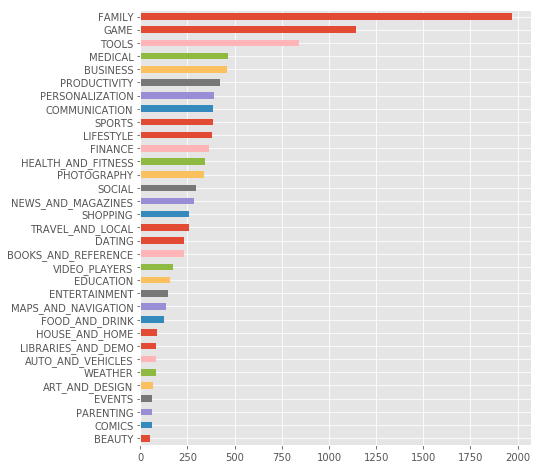

In [23]:
app_cat = pf.Category.value_counts().sort_values()
app_cat.plot(kind='barh', figsize=(7,8))
plt.style.use('seaborn-dark-palette')

可以看到，家庭、游戏和工具是遥遥领先于其它APP类型的

#### app 评分

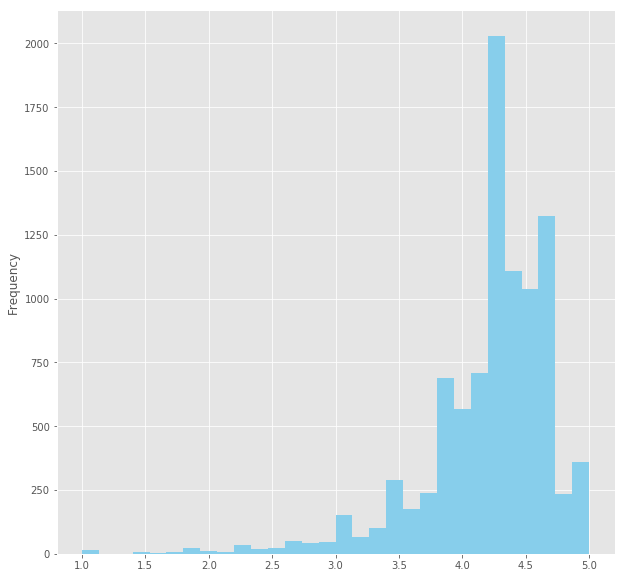

In [24]:
pf.Rating.plot(kind='hist', bins=30, color='#87CEEB', figsize=(10,10))

评分大多集中在4-5分，这可能与数据采集的方式有关。

#### app 评论数

评论数为0的app个数为596


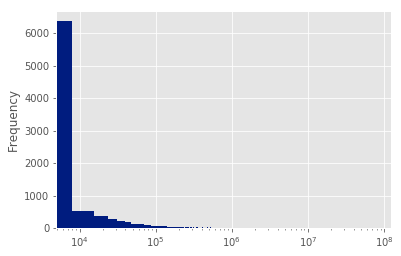

In [25]:
pf.Reviews.plot(kind='hist', bins=10000, logx=True)
print('评论数为0的app个数为{}'.format(pf[pf.Reviews == 0].shape[0]))

大多数的评论数都较少，只有少数的评论数很高。

In [26]:
pf.Reviews.describe()

count    1.084000e+04
mean     4.441529e+05
std      2.927761e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.477550e+04
max      7.815831e+07
Name: Reviews, dtype: float64

#### app 安装数

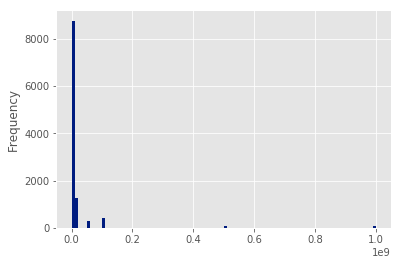

In [27]:
pf.Installs.plot(kind='hist', bins=100)

有几个安装数特别高的软件，其它都低于2e8

In [28]:
pf.Installs.describe()

count    1.084000e+04
mean     1.546434e+07
std      8.502936e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

#### app 是否收费

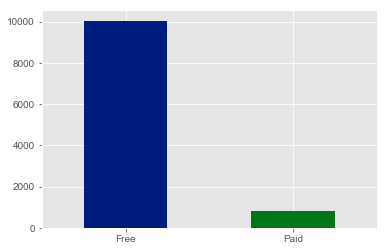

In [29]:
pf.Type.value_counts().plot(kind='bar', rot=0)
plt.style.use('seaborn-ticks')

收费的app占少数，那么收费app的价格是多少呢？

25.039999999999953

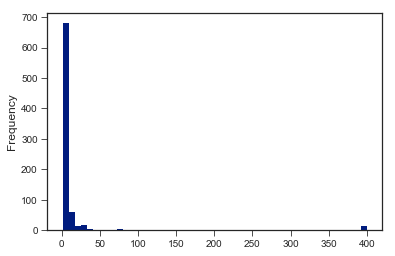

In [30]:
pf[pf.Type == 'Paid'].Price.plot(kind='hist', bins=50)
pf[pf.Type == 'Paid'].Price.quantile(0.95)

只有少数价格较高，95%app低于25美元，75%的app低于5美元

#### app 大小

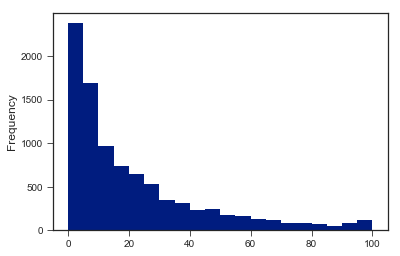

In [31]:
pf.Size.plot(kind='hist', bins=20)

全部都小于100M，以小于20M的居多。

#### app 分级

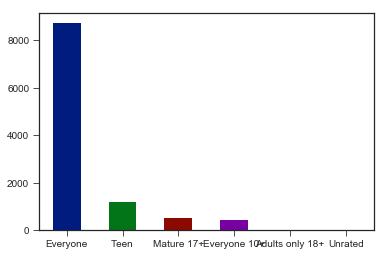

In [32]:
pf['Content Rating'].value_counts().plot(kind='bar', rot=0)

#### app 最后更新时间

2010-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2011-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2012-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2013-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2014-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2015-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2016-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2017-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2018-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
Freq: A-DEC, Name: Last Updated, dtype: object

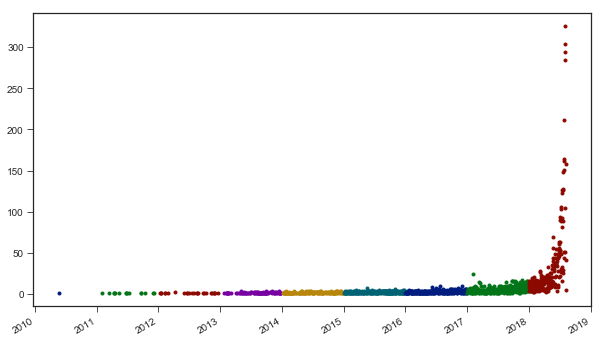

In [33]:
app_update = pf['Last Updated'].value_counts()
app_update.groupby(pd.Grouper(freq='Y')).plot(style='.', figsize=(10,6))

这个数据是2018年获取的，大多数软件的最近一次更新时间是2018年，最久没更新的软件是2010年更新的。

#### app 版本
我把app版本替换成小数。如版本4.2.8替换成4.28

In [34]:
def ver_to_float(obj):
    obj = list(filter(lambda ch: ch in '0123456789.', str(obj)))
    obj = ''.join(obj)
    obj_list = str(obj).split('.')
    decimal = ''.join(obj_list[1:])
    try :
        decimal_try = float(decimal)
    except ValueError:
        new = np.nan
    else:
        new = obj_list[0] + '.' + decimal
    return new

In [35]:
pf['Current Ver'] = pf['Current Ver'].apply(ver_to_float).astype('float64')

In [36]:
pf['Current Ver'].describe()

count    9.177000e+03
mean     1.360615e+03
std      2.190561e+04
min      2.000000e-03
25%      1.103000e+00
50%      1.973400e+00
75%      3.600000e+00
max      1.000001e+06
Name: Current Ver, dtype: float64

我觉得版本数过大（大于100）都是不合理的，所以去掉它们

count    9104.000000
mean        3.120087
std         4.641525
min         0.002000
25%         1.100000
50%         1.920000
75%         3.500000
max        99.003575
Name: Current Ver, dtype: float64

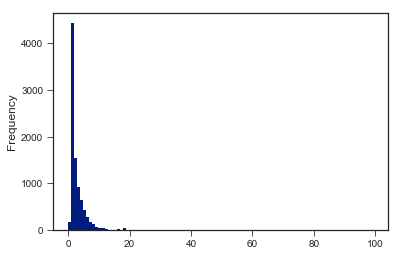

In [37]:
pf[pf['Current Ver']<100]['Current Ver'].plot(kind='hist', bins=100)
pf[pf['Current Ver']<100]['Current Ver'].describe()

大多数都很小

#### 数据中的Genres,App,Android Ver这三列不进行分析。

### 2. 双变量探索

#### 总览

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


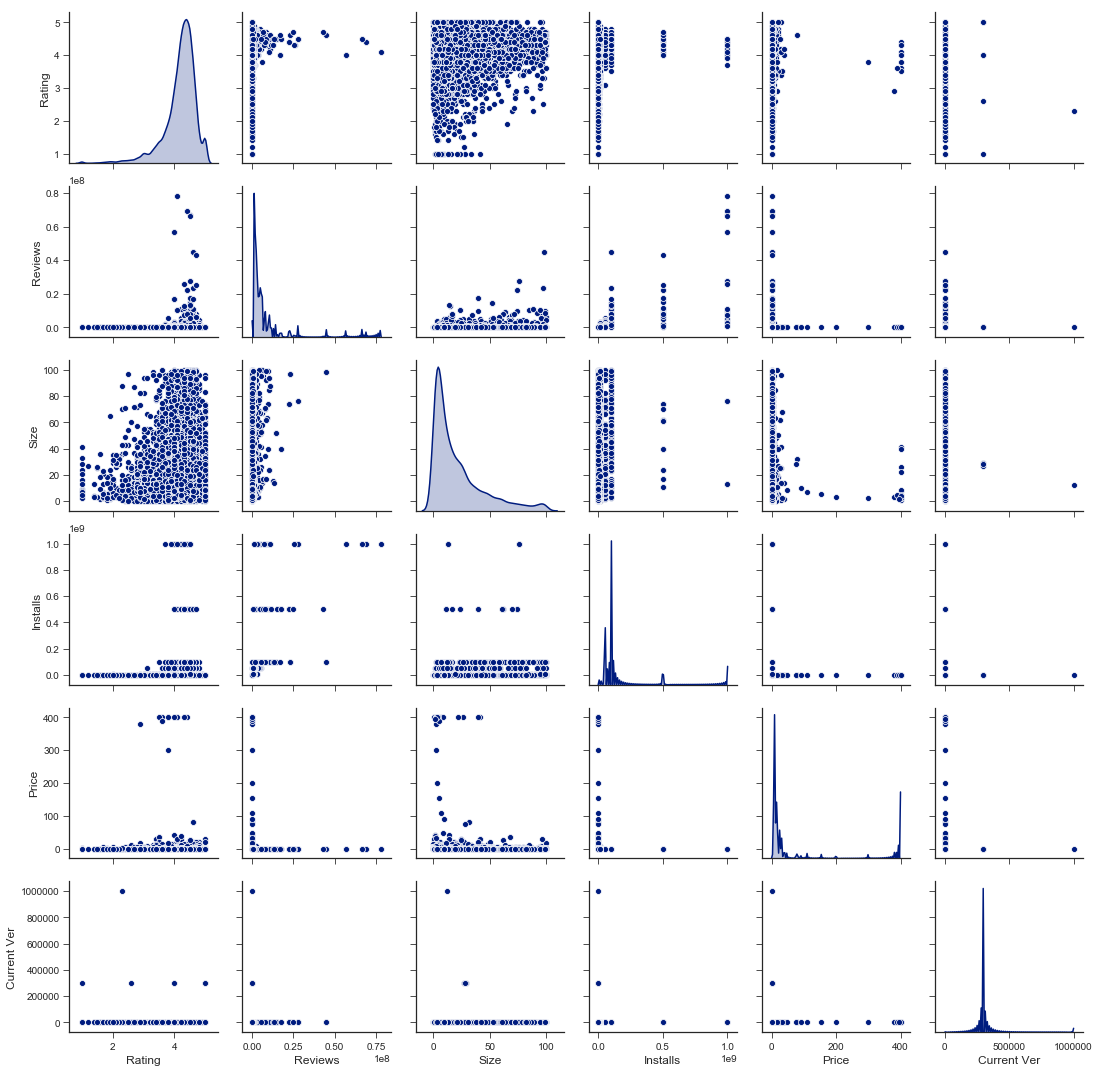

In [38]:
sns.pairplot(pf, dropna=True, diag_kind='kde')

In [39]:
pf.corr()

,Rating,Reviews,Size,Installs,Price,Current Ver
Rating,1.000000,0.068141,0.083734,0.051355,-0.021903,-0.038672
Reviews,0.068141,1.000000,0.238215,0.643122,-0.009667,-0.009528
Size,0.083734,0.238215,1.000000,0.164787,-0.023006,0.015753
Installs,0.051355,0.643122,0.164787,1.000000,-0.011689,-0.010170
Price,-0.021903,-0.009667,-0.023006,-0.011689,1.000000,-0.004095
Current Ver,-0.038672,-0.009528,0.015753,-0.010170,-0.004095,1.000000


看起来，除了安装数和评论数有相关外，其它都没有明显的相关性。

#### 2.1 与类别（Category）有关的分析

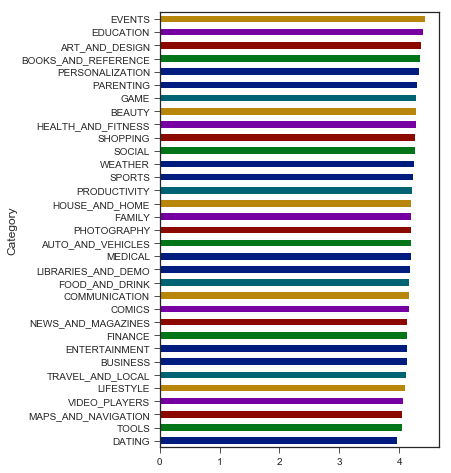

In [40]:
# 不同类的平均分
pf.groupby('Category').Rating.mean().sort_values().plot(kind='barh', figsize=(5,8))

不同类别的平均分相差不大，大多高于4分，DATING类最低。

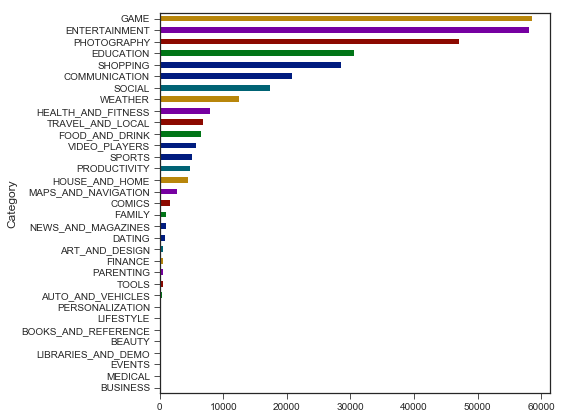

In [41]:
# 不同类的评论数的中位数
# 使用中位数可以防止某些过高的值的影响
pf.groupby('Category').Reviews.median().sort_values().plot(kind='barh', figsize=(7,7))

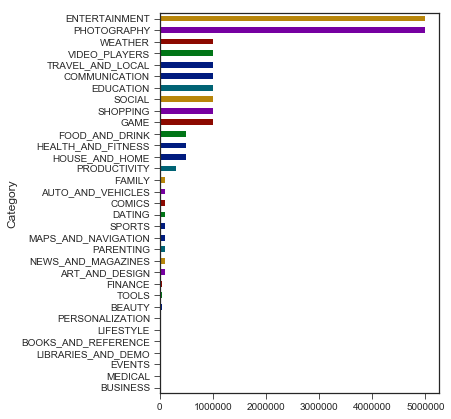

In [42]:
# 不同类的安装数的中位数
pf.groupby('Category').Installs.median().sort_values().plot(kind='barh', figsize=(5,7))

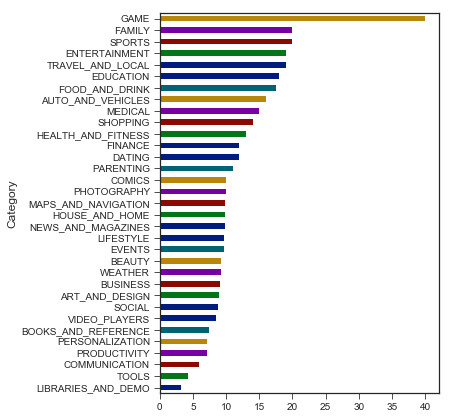

In [43]:
# 不同类的大小的中位数
pf.groupby('Category').Size.median().sort_values().plot(kind='barh', figsize=(5,7))

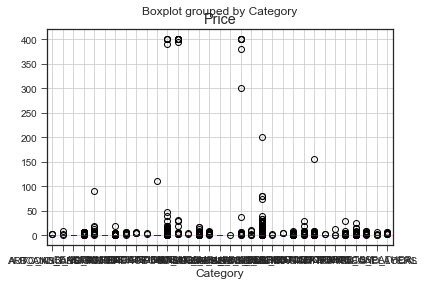

In [44]:
# 不同类的价格
pf.boxplot(column='Price', by='Category')

由于绝大多数的软件都是免费的，所以上面的箱型图看起来都是一样的。为了比较，统计不同类中收费app的百分比会更好。

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


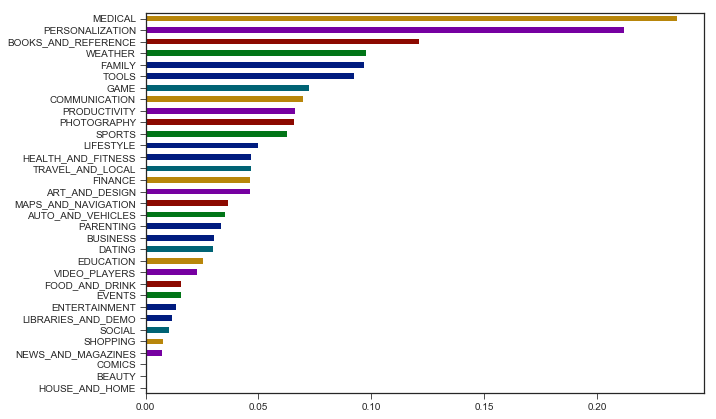

In [45]:
app_paid_count = pf[pf.Type == 'Paid'].groupby('Category').size()
app_paid_count.name = 'paid_count'
app_cat.name = 'total'
app_paid = pd.concat([app_cat, app_paid_count], axis=1)
app_paid = app_paid.fillna(0)
app_paid['prop'] = app_paid.paid_count / app_paid.total
app_paid.prop.sort_values().plot(kind='barh', figsize=(10,7))

In [46]:
# 不同类的分级情况
app_grading = pf.groupby(['Category','Content Rating']).size().unstack()
app_grading.columns = ['Everone', 'Everyone 10+', 'Teen', 'Mature 17+', 'Adults only 18+', 'Unrated']

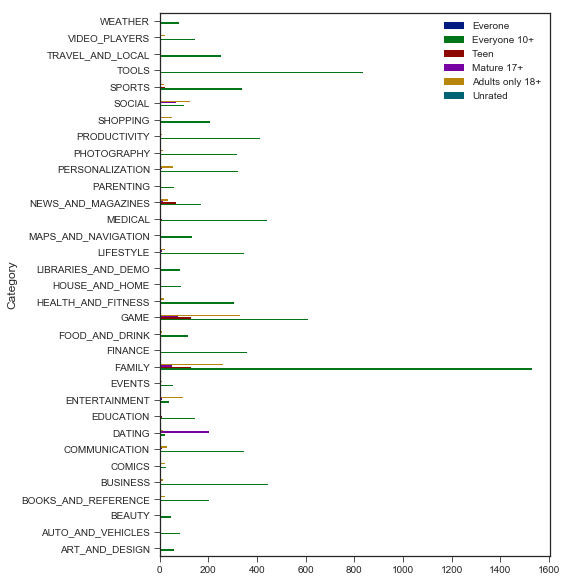

In [47]:
app_grading.plot(kind='barh', figsize=(7,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C6A8705860>,
      dtype=object)

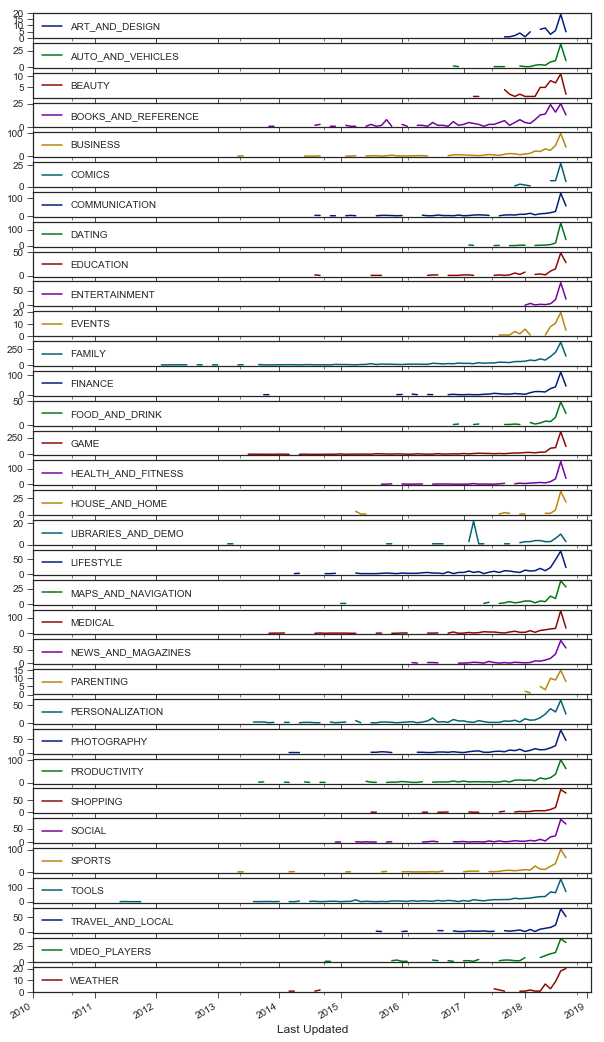

In [48]:
app_cat_update = pf.groupby(['Category', 'Last Updated']).size()
app_cat_update = app_cat_update.groupby(['Category', pd.Grouper(freq='M', level=1)]).sum()
app_cat_update.unstack(level=0).plot(style='-', figsize=(10,20), subplots=True)

对不同类别的这些列做一个总结：
1. 评分方面，平均分最高的三类apps是：**时事，教育，艺术设计**
2. 在价格方面，收费Apps占比最高的三类是：**医疗，个性化，图书参考**
3. 在apps大小方面，**Game**明显高于其它，其次是 **Family和Sports**
4. 在安装数量方面，**娱乐和照相**明显高于其它，而_天气，视频，旅行，社交，教育，社会，购物，游戏_的安装数属于第二梯队。
5. 在评论数方面，**游戏，娱乐，照相**排在前三。
6. 大多数的类别分级情况都是Everyone最多。例外的有：
    - Social类中，18+的最多，其次是Everyone，然后是17+
    - Dating类和enterainment类中，大多数都是17+/18+
    - 在Game类和Family中，18+的数量是次于Everyone的第二多的。
7. 所有类的大多数apps都是最近更新的，但是Libraries and Demo 和Books and reference两类有不少软件更新比较滞后。

### 2.2 与安装数有关的分析

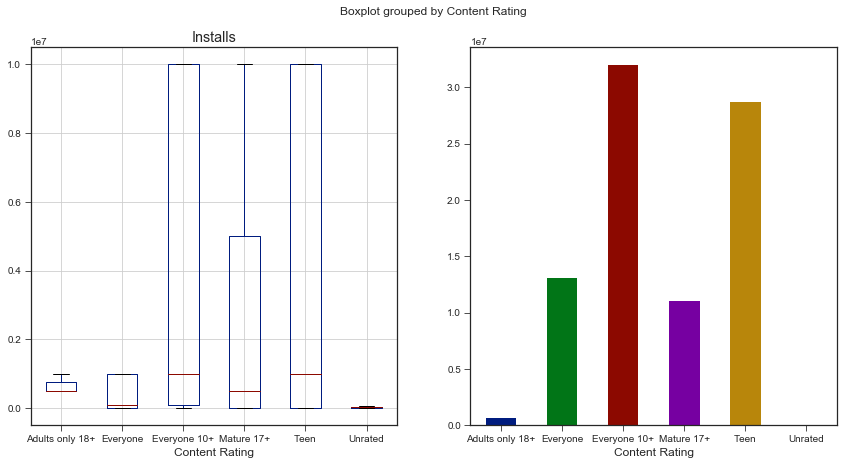

In [49]:
# 安装数与评级
fig, ax = plt.subplots(1,2, figsize=(14,7))
pf.boxplot(column='Installs', by='Content Rating',showfliers=False, ax=ax[0])
pf.groupby('Content Rating').Installs.mean().plot(kind='bar', label='Mean Installs',
                                                 ax=ax[1], rot=0)

    箱型图没有显示异常值。图中有些分级的平均安装数在箱型图外是因为异常值过大。
Everyone级别作为apps数量最多的级别，安装数总体来说比较低（可能是因为有些软件安装数太少了）。

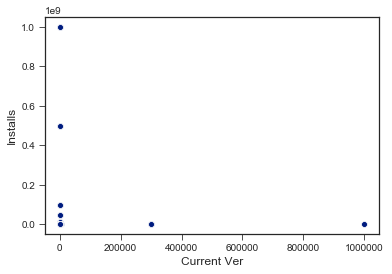

In [50]:
# 安装数与版本
sns.scatterplot(x='Current Ver', y='Installs', data=pf)

这个图太糟糕了，因为有些软件的安装数太高，而有些软件的版本号又太大。过滤一些，过滤标准：  
- 为了便于观察大多数数据的特征，安装数的上限选取5e7，因为5e7是所有apps安装数的95%分位值。
- 版本号小于9.1，所有apps的安装数的95%分位数是9.1

In [64]:
filtered = pf[pf.Installs <= 5e7]
filtered = filtered[filtered['Current Ver'] <= 9.1]

,Current Ver,Installs
Current Ver,1.000000,0.124083
Installs,0.124083,1.000000


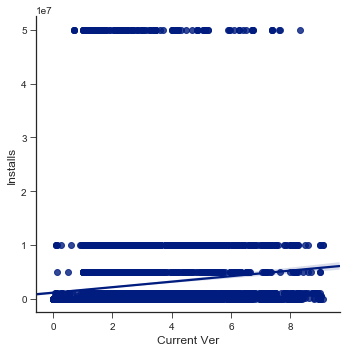

In [65]:
sns.lmplot(x='Current Ver', y='Installs', data=filtered)
filtered[['Current Ver', 'Installs']].corr()

从上图来看，两者有极弱的正相关关系，这是符合常理的。

0.7082082884166556

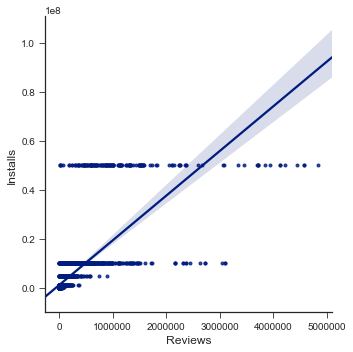

In [67]:
# 安装数与评论数
sns.lmplot(x='Reviews', y='Installs', data=filtered, markers='.')
filtered.Installs.corr(filtered['Reviews'])

两者存在关系也是理所当然的，可以说是有因果关系的。更多的安装数意味着可能有更高的评论数。

0.19805636949707742

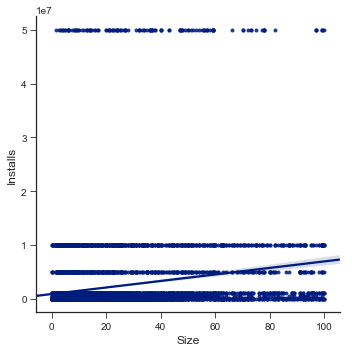

In [68]:
# 安装数与软件大小
sns.lmplot(x='Size', y='Installs', data=filtered, markers='.')
filtered.Installs.corr(filtered.Size)

有趣的是，安装数和大小也存在很弱的正相关关系。原因可能是：好的软件对应的会大一些，对应的安装数多一些。

Type
Free    2.585594e+06
Paid    9.519200e+04
Name: Installs, dtype: float64


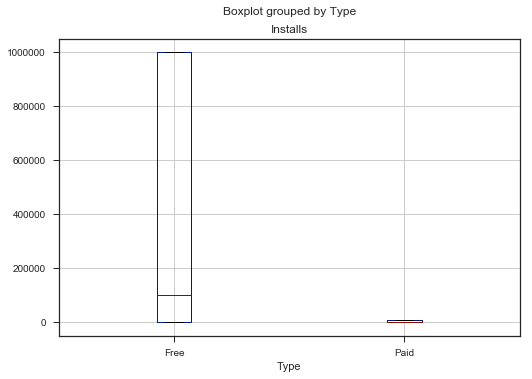

In [104]:
# 安装数与价格
print(filtered.groupby('Type').Installs.mean())
filtered.boxplot(column='Installs', by='Type',showfliers=False)

免费类的apps的安装数明显是高于付款的apps的（无论是比较均值还是中位数）
<br>
那么收费apps的价格和安装数之间的关系又是怎样呢？

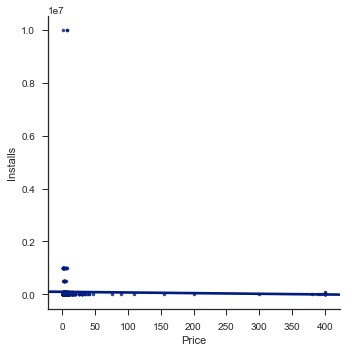

In [107]:
temp = filtered[filtered.Type == 'Paid']
sns.lmplot(x='Price', y='Installs', data=temp, markers='.')

两者毫不相关。收费apps在**医疗，个性化，图书参考**这三类中最多，可能这类apps有其特殊用户群体，其安装数与其价格高低无关。

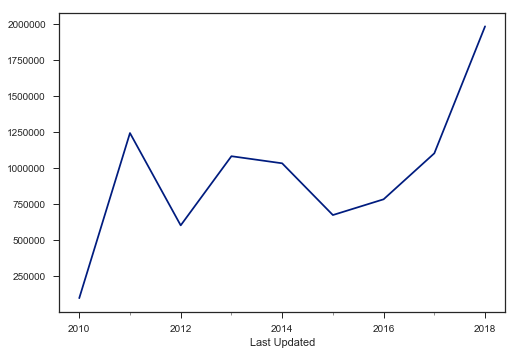

In [126]:
# 最后看一下安装数与最后更新时间，我预测，最后更新时间越近的apps其安装数会相对高一些，但相关性不会太高。
app_ins_update = filtered.groupby('Last Updated').Installs.mean()
app_ins_update.groupby(pd.Grouper(freq='y')).mean().plot(style='-')

和预想中相似，最近更新的软件对应的安装数较高。

总结安装数的分析：
- Everyone级别作为apps数量最多的级别，安装数总体来说比较低（可能是因为有些软件安装数太少了）。
- 版本号和安装数有极弱的正相关关系，这是符合常理的。一个软件更新的版本越多，对应的受众就越多。
- 有趣的是，安装数和大小也存在很弱的正相关关系。原因可能是：好的软件对应的会大一些，对应的安装数多一些。
- 免费类的apps的安装数明显是高于付款的apps的（无论是比较均值还是中位数），但与价格无关。
- 最近更新的软件对应的安装数较高。

## 项目心得：
这是我在学习数据清洗和EDA后独立进行的首个项目，数据来自kaggle。本数据是google apps的信息。我在获取数据后进行了清洗和探索性分析，得到了一些有趣的可视化结果。在分析过程中有些许心得，记录下来：
- 第一遍分析的时候思路不够清晰，第二遍才找到了思路。在分析过程中应该按照单变量，双变量，多变量的顺序来，而不是想到什么分析什么，否则可能会丢失一些重要的信息。
- python处理数据的能力还需要提高。
- 最后的可视化分析时，我意识到学习一些机器学习知识的重要性。下一步会开始这方面的学习。